# In-Depth Analysis/Machine Learning

## Capstone Project 3: Predicting House prices in Seattle


-

In the **Pre-processing part** we already determine which features will be used to create the Model. We need to select a way to measure the reult and regression problems use certain evaluation metrics such as mean squared error (MSE).

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored
from termcolor import colored as cl
import scipy.stats as stats
from scipy.stats import uniform, loguniform
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
    GridSearchCV, RandomizedSearchCV, KFold
from sklearn.decomposition import PCA

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('/Users/pedrorodriguez/Desktop/Springboard/Capstone_3/Step 4- Pre Processing/listing_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 3817 non-null   int64  
 1   id                         3817 non-null   int64  
 2   latitude                   3817 non-null   float64
 3   longitude                  3817 non-null   float64
 4   zipcode                    3817 non-null   int64  
 5   property_type              3817 non-null   object 
 6   room_type                  3817 non-null   object 
 7   price                      3817 non-null   float64
 8   accommodates               3817 non-null   int64  
 9   cleaning_fee               3817 non-null   float64
 10  availability_30            3817 non-null   int64  
 11  bathrooms                  3817 non-null   float64
 12  bedrooms                   3817 non-null   float64
 13  review_scores_rating       3817 non-null   float

In [3]:
house = df[df['property_type'] == 'House']
del house['property_type']
del house['room_type']
house.head()

,Unnamed: 0,id,latitude,longitude,zipcode,price,accommodates,cleaning_fee,availability_30,bathrooms,bedrooms,review_scores_rating,review_scores_cleanliness
2,2,3308979,47.629724,-122.369483,98119,975.0,11,300.0,1,4.5,5.0,97.0,10.0
4,4,278830,47.632918,-122.372471,98119,450.0,6,125.0,30,2.0,3.0,92.0,9.0
5,5,5956968,47.630525,-122.366174,98119,120.0,2,40.0,0,1.0,1.0,95.0,10.0
6,6,1909058,47.636605,-122.368519,98119,80.0,2,0.0,20,1.0,1.0,99.0,10.0
10,10,175576,47.635482,-122.358478,98119,95.0,2,15.0,0,1.0,1.0,97.0,10.0


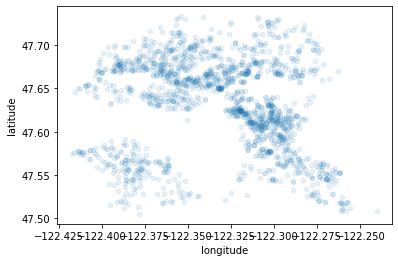

In [4]:
house.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

### Split to train and test data

Let scale the data with Standard Scale to better model performance. Before the split, the data by train and test sets. 

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
columns = house.columns
house_scaled = pd.DataFrame(scaler.fit_transform(house), columns= columns)
house_scaled.head()

,Unnamed: 0,id,latitude,longitude,zipcode,price,accommodates,cleaning_fee,availability_30,bathrooms,bedrooms,review_scores_rating,review_scores_cleanliness
0,-1.707572,-0.618126,-0.032361,-0.990443,0.041822,7.886488,3.056870,4.376806,-1.304104,4.422534,3.298021,0.488928,0.549869
1,-1.705824,-1.630751,0.028767,-1.070547,0.041822,2.972926,0.979071,1.331123,1.056265,0.864716,1.353322,0.346014,0.269845
2,-1.704950,0.266788,-0.017026,-0.901714,0.041822,-0.115599,-0.683168,-0.148209,-1.385496,-0.558411,-0.591377,0.431762,0.549869
3,-1.704076,-1.085956,0.099326,-0.964591,0.041822,-0.489966,-0.683168,-0.844366,0.242344,-0.558411,-0.591377,0.546094,0.549869
4,-1.700579,-1.665257,0.077821,-0.695349,0.041822,-0.349578,-0.683168,-0.583307,-1.385496,-0.558411,-0.591377,0.488928,0.549869


In [7]:
from sklearn.model_selection import train_test_split

X = house_scaled[['longitude', 'latitude', 'accommodates', 'availability_30','cleaning_fee', 'bedrooms', 'bathrooms']].values
y = house_scaled['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [8]:
def calculate_residual_percentile(pred, actual, percentile):
    """Calculate percentile bounds of positive and negative residuals"""
    import numpy as np
    resid = actual - pred
    
    #Create Positive and Negative Condition Arrays
    condition_pos = resid > 0
    condition_neg = resid < 0
    
    #Create arrays for positive and negative residuals
    pos_residuals = np.extract(condition_pos, resid)
    neg_residuals = np.extract(condition_neg, resid)
    
    #Calculate Percentile
    pos_percentile = np.percentile(pos_residuals, percentile)
    neg_percentile = np.percentile(neg_residuals, 100-percentile)
    pos_percentile = round(pos_percentile,4)
    neg_percentile = round(neg_percentile,4)
    return neg_percentile, pos_percentile
 

## Modeling

The data was split into train, validation, and test sets, as I plan to use the validation set for hyperparameter tuning. 

First I will run a linear regression, random forest, and gradient boosting model with the defaults and no tuning to get some baseline scores.

#### Evaluate performance based on the following metrics:

- Mean Absolute Error (MAE): represents the difference between the original and predicted values extracted by averaged the absolute difference over the data set.

- Root Mean Squared Error (RMSE): is the error rate by the square root of MSE.

- R-squared (Coefficient of determination): The coefficient of how well the values fit compared to the original values. The value from 0 to 1 interpreted as percentages. The higher the value is, the better the model is.



### Linear Regression

Regression analysis is one of the most important fields in statistics and machine learning. There are many regression methods available. Linear regression is probably one of the most important and widely used regression techniques. It’s among the simplest regression methods. One of its main advantages is the ease of interpreting results.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [10]:
lr_predictions = lr.predict(X_test)
lr_train_score = lr.score(X_train, y_train)
lr_test_score = lr.score(X_test, y_test)
lr_mae = np.mean(abs(lr_predictions - y_test))
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))

print('Base Linear Regression Train Score:      ', lr_train_score)
print('Base Linear Regression Test Score:       ', lr_test_score)
print('Base Linear Regression MAE:              ',lr_mae)
print('Base Linear Regression RMSE:             ',lr_rmse)

Base Linear Regression Train Score:       0.6426944183198834
Base Linear Regression Test Score:        0.6042505328338856
Base Linear Regression MAE:               0.4023655280819865
Base Linear Regression RMSE:              0.7330551811413651


The Linear Regression has a Test score of 0.60. This score is weak but is still capable of solving a real problem.

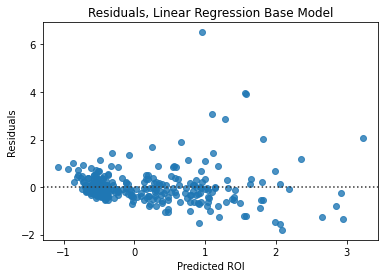

In [11]:
sns.residplot(x = lr_predictions, y = y_test - lr_predictions)
plt.title('Residuals, Linear Regression Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

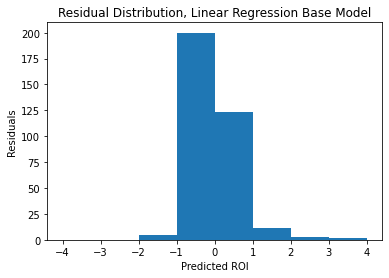

In [12]:
plt.hist(y_test - lr_predictions, bins = np.arange(-4, 5))
plt.title('Residual Distribution, Linear Regression Base Model', size= 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [13]:
lr_90_percentile = calculate_residual_percentile(lr_predictions, y_test ,90)
print('Base Linear Regression Residuals, 90th percentile: ', lr_90_percentile)

Base Linear Regression Residuals, 90th percentile:  (-0.5697, 1.2624)


The residuals are centered bellow zero and have a long tail towards the positive side.

### Random Forest

A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique.

In [14]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100, random_state = 0, oob_score = True)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=0)

In [15]:
rf_prediction = rf.predict(X_test)
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
rf_mae = np.mean(abs(rf_prediction - y_test))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_prediction))

In [16]:
print('Base Random Forest Train Score:      ', rf_train_score)
print('Base Random Forest Test Score:       ', rf_test_score)
print('Base Random Forest MAE:              ', rf_mae)
print('Base Random Forest RMSE:             ', rf_rmse)

Base Random Forest Train Score:       0.94900097859599
Base Random Forest Test Score:        0.6108714502618214
Base Random Forest MAE:               0.3973408482522743
Base Random Forest RMSE:              0.7268972836866974


The random forest model has a Test score of 0.59. This score is weak meaning we need to look how to improve the score.

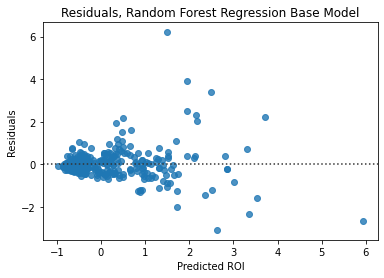

In [17]:
sns.residplot(x = rf_prediction, y = y_test - rf_prediction)
plt.title('Residuals, Random Forest Regression Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

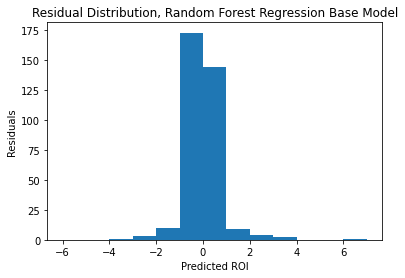

In [18]:
plt.hist(y_test - rf_prediction, bins = np.arange(-6, 8))
plt.title('Residual Distribution, Random Forest Regression Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [19]:
rf_90_percentile = calculate_residual_percentile(rf_prediction, y_test ,90)
print('Base Random Forest Residuals, 90th percentile: ', rf_90_percentile)

Base Random Forest Residuals, 90th percentile:  (-0.6789, 0.981)


The residuals are centered just below zero, indicating prices with where the model over-estimating the low ROI. 90 Percent of the residuals are between 0.67 and 0.98 ROI.

### Gradient Boosting

Gradient boosting is also known as gradient tree boosting, stochastic gradient boosting (an extension), and gradient boosting machines, or GBM for short.

The algorithm provides hyperparameters that should be tuned for a specific dataset.

- The number of trees or estimators in the model.
- The learning rate of the model.
- The row and column sampling rate for stochastic models.
- The maximum tree depth.
- The minimum tree weight.
- The regularization terms alpha and lambda.



In [20]:
from sklearn.ensemble import GradientBoostingRegressor

boost = GradientBoostingRegressor(random_state = 0)
boost.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [21]:
boost_predictions = boost.predict(X_test)
boost_train_score = boost.score(X_train, y_train)
boost_test_score = boost.score(X_test, y_test)
boost_mae = np.mean(abs(boost_predictions - y_test))
boost_rmse = np.sqrt(mean_squared_error(y_test, boost_predictions))

print('Base Gradient Boost Train Score:     ', boost_train_score)
print('Base Gradient Boost Test Score:      ', boost_test_score)
print('Base Gradient Boost MAE:             ', boost_mae)
print('Base Gradient Boost RSME:            ',boost_rmse)

Base Gradient Boost Train Score:      0.821127369404369
Base Gradient Boost Test Score:       0.6389439502251337
Base Gradient Boost MAE:              0.38321139865450515
Base Gradient Boost RSME:             0.7001866262970871


The Gradient Boosting has a much better test score of 0.62 compared to the Lineal Rigression which scored 0.60.

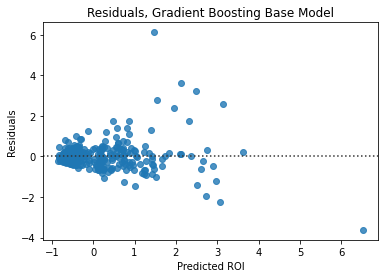

In [22]:
sns.residplot(x = boost_predictions, y = y_test - boost_predictions)
plt.title('Residuals, Gradient Boosting Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

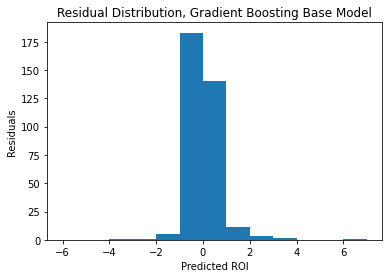

In [23]:
plt.hist(y_test - boost_predictions, bins = np.arange(-6, 8))
plt.title('Residual Distribution, Gradient Boosting Base Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [24]:
rf_90_percentile = calculate_residual_percentile(boost_predictions, y_test ,90)
print('Base Random Forest Residuals, 90th percentile: ', rf_90_percentile)

Base Random Forest Residuals, 90th percentile:  (-0.6152, 1.0294)


The residuals are centered bellow zero and have a long tail towards the positive side.

### Extreme Gradient Boosting

Unlike Gradient Boost, XGBoost makes use of regularization parameters that helps against overfitting.

In [25]:
from xgboost import XGBRegressor

In [26]:
xgb  = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
xgb_predictions = xgb.predict(X_test)
xgb_train_score = xgb.score(X_train, y_train)
xgb_test_score = xgb.score(X_test, y_test)
xgb_mae = np.mean(abs(xgb_predictions - y_test))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))

In [28]:
print('Base XGB Train Score:     ', xgb_train_score)
print('Base XGB Test Score:      ', xgb_test_score)
print('Base XGB MAE:             ', xgb_mae)
print('Base XGB RSME:            ', xgb_rmse)

Base XGB Train Score:      0.9941029886178818
Base XGB Test Score:       0.6065254711537946
Base XGB MAE:              0.41108103442753513
Base XGB RSME:             0.7309451860887742


#### Base Model Summary

In [29]:
print('Base Linear Regression:')
print('Base Linear Regression Train Score:  ', lr_train_score)
print('Base Linear Regression Test Score:   ', lr_test_score)
print('Base Linear Regression MAE:          ',lr_mae)
print('Base Linear Regression RMSE:         ',lr_rmse)
print('-'*71)
print('Base Random Forest: ')
print('Base Random Forest Train Score:      ', rf_train_score)
print('Base Random Forest Test Score:       ', rf_test_score)
print('Base Random Forest MAE:              ', rf_mae)
print('Base Random Forest RMSE:             ', rf_rmse)
print('-'*71)
print('Base Gradient Boost:')
print('Base Gradient Boost Train Score:     ', boost_train_score)
print('Base Gradient Boost Test Score:      ', boost_test_score)
print('Base Gradient Boost MAE:             ', boost_mae)
print('Base Gradient Boost RMSE:            ',boost_rmse)
print('-'*71)
print('Base Extreme Gradient Boost:')
print('Base XGB Train Score:                ', xgb_train_score)
print('Base XGB Test Score:                 ', xgb_test_score)
print('Base XGB MAE:                        ', xgb_mae)
print('Base XGB RMSE:                       ', xgb_rmse)

Base Linear Regression:
Base Linear Regression Train Score:   0.6426944183198834
Base Linear Regression Test Score:    0.6042505328338856
Base Linear Regression MAE:           0.4023655280819865
Base Linear Regression RMSE:          0.7330551811413651
-----------------------------------------------------------------------
Base Random Forest: 
Base Random Forest Train Score:       0.94900097859599
Base Random Forest Test Score:        0.6108714502618214
Base Random Forest MAE:               0.3973408482522743
Base Random Forest RMSE:              0.7268972836866974
-----------------------------------------------------------------------
Base Gradient Boost:
Base Gradient Boost Train Score:      0.821127369404369
Base Gradient Boost Test Score:       0.6389439502251337
Base Gradient Boost MAE:              0.38321139865450515
Base Gradient Boost RMSE:             0.7001866262970871
-----------------------------------------------------------------------
Base Extreme Gradient Boost:
Base XG

The best model performing is the Gradient boost model have the lowest MAE(38%), RMSE(70%) and the highest test score with 63%. 

## Model Tuning

Tuning is the process of maximizing a model's performance without overfitting or creating too high of a variance. This is accomplished by selecting appropriate “hyperparameters.”
I will try to increase the score of every model and at the end select the best prediction score.

In [30]:
kfolds = KFold(n_splits=10, shuffle=True)

#### Linear Regression Tuning

I will attempt to fit a ridge and lasso model to see if the results are improved. Based on the low score on the training set, it most likely underfitting.

In [31]:
from sklearn.linear_model import Ridge

alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    
    ridge = Ridge(alpha = alpha, fit_intercept = True, random_state = 0)
    ridge.fit(X_train, y_train)
    train_error = np.sqrt(mean_squared_error(y_train, ridge.predict(X_train)))
    test_error = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))
    print('alpha: {:7} | train error: {:5} | val error: {:6}'.
          format(alpha,
                 round(train_error,10),
                 round(test_error,10)))

alpha:   1e-06 | train error: 0.5687510773 | val error: 0.7330551811
alpha:   1e-05 | train error: 0.5687510773 | val error: 0.7330551811
alpha:  0.0001 | train error: 0.5687510773 | val error: 0.7330551805
alpha:   0.001 | train error: 0.5687510773 | val error: 0.7330551744
alpha:    0.01 | train error: 0.5687510773 | val error: 0.7330551138
alpha:     0.1 | train error: 0.5687510787 | val error: 0.7330545094
alpha:       1 | train error: 0.5687512157 | val error: 0.7330486697
alpha:      10 | train error: 0.5687641288 | val error: 0.733009678
alpha:     100 | train error: 0.5695946393 | val error: 0.7339241736


In [32]:
ridge = Ridge(alpha = .000001)
ridge.fit(X_train, y_train)

Ridge(alpha=1e-06)

In [33]:
from sklearn.linear_model import Lasso

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for alpha in alphas:
    
    lasso = Lasso(alpha = alpha, fit_intercept = True, random_state = 1)
    lasso.fit(X_train, y_train)
    new_train_error = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))
    new_validation_error = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))
    print('alpha: {:7} | train error: {:5} | val error: {:6}'.
          format(alpha,
                 round(new_train_error,10),
                 round(new_validation_error,10)))

alpha:   1e-05 | train error: 0.5687510777 | val error: 0.7330581712
alpha:  0.0001 | train error: 0.5687511172 | val error: 0.73308517
alpha:   0.001 | train error: 0.5687550707 | val error: 0.7333587847
alpha:    0.01 | train error: 0.5690352427 | val error: 0.7359320441
alpha:     0.1 | train error: 0.5842892415 | val error: 0.7721568861
alpha:       1 | train error: 0.9514858454 | val error: 1.1761102078
alpha:      10 | train error: 0.9514858454 | val error: 1.1761102078


In [34]:
lasso = Lasso(alpha = .000001)
lasso.fit(X_train, y_train)

Lasso(alpha=1e-06)

In [35]:
lasso_train_score = lasso.score(X_train, y_train)
lasso_test_score = lasso.score(X_test, y_test)


print('Base Linear Regression Train Score:      ', lr.score(X_train, y_train))
print('Base Linear Regression Test Score:       ', lr.score(X_test, y_test))
print('-'*72)
print('Ridge Regression Train Score:            ', ridge.score(X_train, y_train))
print('Ridge Regression Test Score:             ', ridge.score(X_test, y_test))
print('-'*72)
print('Lasso Regression Train Score:            ', lasso_train_score)
print('Lasso Regression Test Score:             ', lasso_test_score)

Base Linear Regression Train Score:       0.6426944183198834
Base Linear Regression Test Score:        0.6042505328338856
------------------------------------------------------------------------
Ridge Regression Train Score:             0.6426944183198834
Ridge Regression Test Score:              0.6042505328411631
------------------------------------------------------------------------
Lasso Regression Train Score:             0.6426944183148688
Lasso Regression Test Score:              0.6042502132783034


The lasso regularization is with an alpha value of 0.000001 is performing the best on the Test data, however, the change is minimal. The Linear regression only has a very slight improvement.

In [36]:
lasso_predictions = lasso.predict(X_test)
lasso_mae = np.mean(abs(lasso_predictions - y_test))
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_predictions))

print('Base Linear Regression MAE:   ',lr_mae)
print('Base Linear Regression RMSE:  ',lr_rmse)
print('Lasso Regresson MAE:          ',lasso_mae)
print('Lasso Regression RSME:        ', lasso_rmse)


Base Linear Regression MAE:    0.4023655280819865
Base Linear Regression RMSE:   0.7330551811413651
Lasso Regresson MAE:           0.40236559025658386
Lasso Regression RSME:         0.7330554771011167


The Lasso model also shows a minimal improvement on the MAE and RMSE metrics.

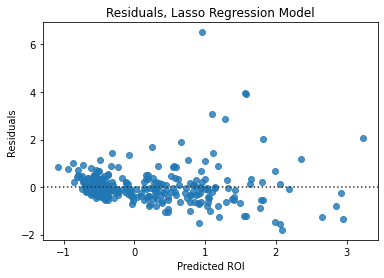

In [37]:
sns.residplot(x = lasso_predictions, y = y_test - lasso_predictions)
plt.title('Residuals, Lasso Regression Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

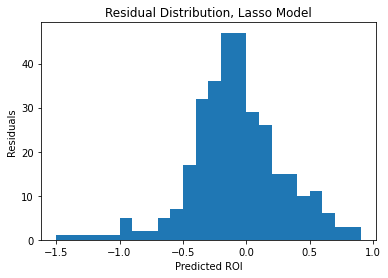

In [38]:
plt.hist(y_test - lasso_predictions, bins = np.arange(-1.5, 1, 0.1))
plt.title('Residual Distribution, Lasso Model', size = 12)
plt.ylabel('Residuals', size = 10)
plt.xlabel('Predicted ROI', size = 10)
plt.show()

In [39]:
lasso_90_percentile = calculate_residual_percentile(lasso_predictions, y_test ,90)
print('Lasso Residuals, 90th percentile: ', lasso_90_percentile)

Lasso Residuals, 90th percentile:  (-0.5697, 1.2624)


As with the base model, the residuals are still centered above zero, and the negative residuals have a heavy tail. 

#### Random Forest Tuning

To tune the Random Forest, I have to evaluate each feature's importance for the Random Forest model.

In [40]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = ['longitude', 'latitude', 'accommodates', 'availability_30','cleaning_fee', 'bedrooms', 'bathrooms'], columns = ['importance']).sort_values('importance', ascending = False)
print(feature_importances.head(10))

                 importance
bedrooms           0.615277
latitude           0.099712
longitude          0.091915
cleaning_fee       0.066988
bathrooms          0.056027
availability_30    0.038774
accommodates       0.031307


In [41]:
X_2 = house_scaled[['longitude', 'latitude', 'accommodates', 'cleaning_fee', 'bedrooms']].values
y_2 = house_scaled['price'].values

In [42]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size = 0.25, random_state = 0)

In [43]:
rf_2 = RandomForestRegressor(n_jobs = -1, n_estimators = 100, random_state = 42)

rf_2.fit(X_2_train, y_2_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [44]:
rf_2_predictions = rf_2.predict(X_2_test)
rf_2_train_score = rf_2.score(X_2_train, y_2_train)
rf_2_test_score = rf_2.score(X_2_test, y_2_test)
rf_2_mae = np.mean(abs(rf_2_predictions - y_2_test))
rf_2_rmse = np.sqrt(mean_squared_error(y_2_test, rf_2_predictions))

print('Base Random Forest:')
print(' Train Score:      ', rf_train_score)
print(' Validation Score: ', rf_test_score)
print(' MAE:              ', rf_mae)
print(' RMSE:             ', rf_rmse)
print('Reduced Dimension Random Forest:')
print(' Train Score:      ', rf_2_train_score)
print(' Test Score:       ', rf_2_test_score)
print(' MAE:              ',rf_2_mae)
print(' RMSE:             ',rf_2_rmse)

Base Random Forest:
 Train Score:       0.94900097859599
 Validation Score:  0.6108714502618214
 MAE:               0.3973408482522743
 RMSE:              0.7268972836866974
Reduced Dimension Random Forest:
 Train Score:       0.9506309244750584
 Test Score:        0.6374850141545438
 MAE:               0.36778569657775106
 RMSE:              0.6793451738780799


Cutting the bathroom feature makes the Random Forest increase the scoring metrics to 63.7%.

#### Gradient Boost Tuning

To tune the gradient boost model, I will set up a parameter grid and do a grid search to determine which parameters yield the highest score on the validation set. Next, search over the max_depth, learning_rate, min_samples_leaf, and max_features hyperparameters, all with an increased n_estimators parameter of 1000.

In [45]:
from sklearn.model_selection import ParameterGrid

param_grid = {'learning_rate' : [0.1, 0.05, 0.02], #default 0.1
              'min_samples_leaf' : [1,3], #default 1
              'max_features' : [1, 0.5, 0.2]} #default none (all)

boost_2 = GradientBoostingRegressor(n_estimators = 1000, random_state = 0)

In [46]:
scores = []
best_score = 0
best_param = {}

for p in ParameterGrid(param_grid):
    boost_2.set_params(**p)
    boost_2.fit(X_train, y_train)
    score = boost_2.score(X_test, y_test)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_param = p

In [47]:
print(best_param)
print(best_score)

{'learning_rate': 0.02, 'max_features': 1, 'min_samples_leaf': 3}
0.6741793024221414


The best scoring was found with a learning rate of 0.02, max features of 1, and minimum samples leaf of 3.

In [48]:
boost_2 = GradientBoostingRegressor(learning_rate = 0.07,
                                        max_features = 1,
                                        min_samples_leaf = 3,
                                        random_state = 0)
boost_2.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.07, max_features=1,
                          min_samples_leaf=3, random_state=0)

In [49]:
boost_2_predictions = boost_2.predict(X_test)
boost_2_train_score = boost_2.score(X_train, y_train)
boost_2_test_score = boost_2.score(X_test, y_test)
boost_2_mae = np.mean(abs(boost_2_predictions - y_test))
boost_2_rmse = np.sqrt(mean_squared_error(y_test, boost_2_predictions))
print('Base Gradient Boost:')
print(' Train Score:      ', boost_train_score)
print(' Test Score:       ', boost_test_score)
print(' MAE:              ', boost_mae)
print(' RSME:             ', boost_rmse)
print('-'*72)
print('Tuned Gradient Boost:')
print(' Train Score:      ', boost_2_train_score)
print(' Test Score:       ', boost_2_test_score)
print(' MAE:              ', boost_2_mae)
print(' RSME:             ', boost_2_rmse)

Base Gradient Boost:
 Train Score:       0.821127369404369
 Test Score:        0.6389439502251337
 MAE:               0.38321139865450515
 RSME:              0.7001866262970871
------------------------------------------------------------------------
Tuned Gradient Boost:
 Train Score:       0.758560735407454
 Test Score:        0.6641715110849374
 MAE:               0.3664366289726414
 RSME:              0.6752821436211988


The Tuned Gradient Boost results in a minimal gain in the scoring metrics to 66%.

#### XGBRegression tuning

I will tune the XGBRegressor hyperparameter using Randomized Search CV and GridSearchCV to find the optimal parameters. 

In [50]:
import xgboost as xgb

In [51]:
### XGBoost (GridSearchCV)

MEAN_RESPONSE=y_2_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    """convert log1p rmse to underlying SalePrice error"""
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
    
    
gs = make_pipeline(RobustScaler(),
                   GridSearchCV(ElasticNet(max_iter=100000),
                                param_grid={'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                            'alpha': np.logspace(-4, -2, 9),
                                           },
                                scoring='neg_root_mean_squared_error',
                                refit=True,
                                cv=kfolds,
                                n_jobs=-1,
                                verbose=1
                               ))

gs.fit(X_2_train, y_2_train)
print('best params', gs._final_estimator.best_params_)

Fitting 10 folds for each of 117 candidates, totalling 1170 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s


best params {'alpha': 0.01, 'l1_ratio': 0.01}


[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1170 out of 1170 | elapsed:    1.6s finished


In [52]:
# RandomizedSearch
rs = make_pipeline(RobustScaler(),
                   RandomizedSearchCV(ElasticNet(max_iter=100000),
                                      {'alpha': loguniform(0.0001, 0.1),
                                       'l1_ratio': uniform(0.001, 0.5),
                                      },
                                      scoring='neg_root_mean_squared_error',
                                      refit=True,
                                      cv=kfolds,
                                      n_iter=200,
                                      n_jobs=-1,
                                      verbose=1,
                                     )
                  )

rs.fit(X_2_train, y_2_train)

print('best params', rs._final_estimator.best_params_)
print('best score', -rs._final_estimator.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s


Fitting 10 folds for each of 200 candidates, totalling 2000 fits
best params {'alpha': 0.03216386150014773, 'l1_ratio': 0.006305247948054204}
best score 0.562921535268701


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


**Let's compare the parameters results**

In [53]:
boost_4 = XGBRegressor(n_estimators = 1000, alpha= 0.05, learning_rate=0.01)
boost_4.fit(X_2_train, y_2_train)
boost_5 = XGBRegressor(n_estimators = 1000, alpha= 0.01,learning_rate=0.01)
boost_5.fit(X_2_train, y_2_train)

XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0.00999999978, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [54]:
boost_4_predictions = boost_4.predict(X_2_test)
boost_4_train_score = boost_4.score(X_2_train, y_2_train)
boost_4_test_score = boost_4.score(X_2_test, y_2_test)
boost_4_mae = np.mean(abs(boost_4_predictions - y_2_test))
boost_4_rmse = np.sqrt(mean_squared_error(y_2_test, boost_4_predictions))


boost_5_predictions = boost_5.predict(X_2_test)
boost_5_train_score = boost_5.score(X_2_train, y_2_train)
boost_5_test_score = boost_5.score(X_2_test, y_2_test)
boost_5_mae = np.mean(abs(boost_5_predictions - y_2_test))
boost_5_rmse = np.sqrt(mean_squared_error(y_2_test, boost_5_predictions))

print('Base Gradient Boost:')
print(' Train Score:      ', boost_train_score)
print(' Test Score:       ', boost_test_score)
print(' MAE:              ', boost_mae)
print(' RMSE:             ', boost_rmse)
print('-'*72)
print('Tune Gradient Boost-1:')
print(' Train Score:      ', boost_5_train_score)
print(' Test Score:       ', boost_5_test_score)
print(' MAE:              ', boost_5_mae)
print(' RMSE:             ', boost_5_rmse)
print('-'*72)
print('Tune Gradient Boost-2:')
print(' Train Score:      ', boost_4_train_score)
print(' Test Score:       ', boost_4_test_score)
print(' MAE:              ', boost_4_mae)
print(' RMSE:             ', boost_4_rmse)

Base Gradient Boost:
 Train Score:       0.821127369404369
 Test Score:        0.6389439502251337
 MAE:               0.38321139865450515
 RMSE:              0.7001866262970871
------------------------------------------------------------------------
Tune Gradient Boost-1:
 Train Score:       0.9432081996308647
 Test Score:        0.6300440491132039
 MAE:               0.3743839281866549
 RMSE:              0.6862818622207193
------------------------------------------------------------------------
Tune Gradient Boost-2:
 Train Score:       0.9462476323845812
 Test Score:        0.6356176290539096
 MAE:               0.37227147615742456
 RMSE:              0.681092645844178


I was tuning the XBGRegression and the score decrease compared to the baseline.

## Model Selection

After produced many iterations of performance tuning to find the optimal solution of each model. Random Forest Regression, XGBoost, Gradient Boost Regression, and XGBoost were tuned by function GridSearchCV provided by scikit-learn to produce the following results listed.

In [55]:
print('      Models                  Test score')
print('Lasso Regression Test Score:  ', round(lasso_test_score, 4))
print('Random Forest Test Score:     ', round(rf_2_test_score, 4)) 
print('Gradient Boost:               ', round(boost_2_test_score,4))
print('XGBoot regression:            ', round(boost_4_test_score,4))

      Models                  Test score
Lasso Regression Test Score:   0.6043
Random Forest Test Score:      0.6375
Gradient Boost:                0.6642
XGBoot regression:             0.6356


In [56]:
print('      Models                  RMSE score')
print('Lasso Regression Test Score:  ', round(lasso_rmse, 4))
print('Random Forest Test Score:     ', round(rf_2_rmse, 4)) 
print('Gradient Boost:               ', round(boost_2_rmse, 4))
print('XGBoot regression:            ', round(boost_4_rmse,4))

      Models                  RMSE score
Lasso Regression Test Score:   0.7331
Random Forest Test Score:      0.6793
Gradient Boost:                0.6753
XGBoot regression:             0.6811


In [57]:
print('      Models                  MAE score')
print('Lasso Regression Test Score:  ', round(lasso_mae, 4))
print('Random Forest Test Score:     ', round(rf_2_mae, 4))
print('Gradient Boost:               ', round(boost_2_mae, 4))
print('XGBoot regression:            ', round(boost_4_mae,4))

      Models                  MAE score
Lasso Regression Test Score:   0.4024
Random Forest Test Score:      0.3678
Gradient Boost:                0.3664
XGBoot regression:             0.3723


I divided the result into categories, R square as Test Score, Root mean squared error as RMSE, and Mean Absolute Error as MAE. The model with the best test score result belongs to Gradient Boost with 66%. This model has the lowest root mean squared error with 72.15 but is not the slower in MAE. Still, this is the model I selected. 